# NB09 — Random Stratified KD Sample: Routing Coherence

**Motivation**: NB05 selected representative KDs as the **top 15 per cluster by mean |ΔY|** (highest-magnitude responders). This introduces a magnitude bias — high-magnitude KDs may have more structured Jacobians, inflating the routing coherence signal. Equal cluster weighting regardless of cluster size is also a distortion.

**This notebook**: replace top-15-by-magnitude with **random-stratified sampling** — 15 KDs drawn uniformly at random within each cluster (seed=99 for reproducibility). Same 15 clusters × 15 KDs = 225 KDs, but now representative of the full perturbation space rather than the extremes.

**Key comparison**:
- NB05 top-by-magnitude: Pearson=0.119, Spearman=0.094
- NB09 random-stratified: if Spearman drops substantially → magnitude bias was real; if similar → signal holds across full distribution

**Also**: compute one-hot Jacobian (∂Y/∂x_onehot = J @ W) for direct comparison with NB08.


In [1]:

lines = [
"import sys, pickle, torch, numpy as np, pandas as pd",
"import warnings; warnings.filterwarnings('ignore')",
"sys.path.insert(0, '/mnt/polished-lake/home/mbeheleramass/state/src')",
"from state.tx.models.state_transition import StateTransitionPerturbationModel",
"from sklearn.metrics.pairwise import cosine_similarity",
"from scipy.stats import pearsonr, spearmanr, sem, mannwhitneyu",
"import matplotlib; matplotlib.use('Agg')",
"import matplotlib.pyplot as plt",
"",
"OUTDIR = '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis'",
"BASE   = '/mnt/polished-lake/artifacts/fellows-shared/life-sciences/state/models/ST-HVG-Replogle/fewshot/hepg2'",
"",
"print('=== NB09: Random Stratified KD Sample ===')",
"print(f'Torch: {torch.__version__}, CUDA: {torch.cuda.is_available()}')",
"",
"# ── Load model ────────────────────────────────────────────────────────────────",
"print('[1] Loading fewshot model...')",
"model = StateTransitionPerturbationModel.load_from_checkpoint(",
"    f'{BASE}/checkpoints/best.ckpt',",
"    map_location='cuda' if torch.cuda.is_available() else 'cpu'",
")",
"model.eval()",
"device = next(model.parameters()).device",
"print(f'  Model on: {device}')",
"",
"var_dims  = pickle.load(open(f'{BASE}/var_dims.pkl', 'rb'))",
"gene_names = list(var_dims['gene_names'])",
"pert_map   = {str(k): v for k, v in torch.load(f'{BASE}/pert_onehot_map.pt', weights_only=False).items()}",
"W = model.pert_encoder[0].weight.detach().cpu().numpy()  # [328, 2024]",
"print(f'  Genes: {len(gene_names)}, Perts: {len(pert_map)}')",
"",
"# ── Load control cells (same seed=42 as NB05) ─────────────────────────────────",
"import anndata as ad",
"DATA = '/mnt/polished-lake/artifacts/fellows-shared/life-sciences/state/data/Replogle-Nadig-Preprint'",
"adata = ad.read_h5ad(f'{DATA}/replogle_hvg.h5ad', backed='r')",
"ctrl_mask = (adata.obs['cell_line'] == 'K562') if 'K562' in adata.obs['cell_line'].values else (adata.obs['gene'] == 'non-targeting')",
"hepg2_mask = adata.obs['cell_line'] == 'HepG2'",
"ctrl_mask  = hepg2_mask & (adata.obs['gene'] == 'non-targeting')",
"ctrl_idx   = np.where(ctrl_mask)[0]",
"rng_ctrl   = np.random.default_rng(42)",
"sample_idx = rng_ctrl.choice(ctrl_idx, size=min(64, len(ctrl_idx)), replace=False)",
"ctrl_cells = torch.tensor(adata.obsm['X_hvg'][sample_idx], dtype=torch.float32).to(device)",
"ctrl_mean  = ctrl_cells.mean(0)",
"print(f'  Control cells: {len(ctrl_idx)} available, using {ctrl_cells.shape[0]}')",
"",
"# ── Load NB05 clusters + ΔY ───────────────────────────────────────────────────",
"print('[2] Loading NB05 cluster assignments...')",
"clusters5 = pd.read_csv(f'{OUTDIR}/nb05_clusters.csv', index_col=0)",
"dy5       = pd.read_parquet(f'{OUTDIR}/nb05_delta_y.parquet')",
"n_clusters = clusters5['cluster'].nunique()",
"print(f'  Clusters: {n_clusters}, KDs: {len(clusters5)}')",
"",
"# ── Random stratified sample: 15 per cluster ─────────────────────────────────",
"print('[3] Random stratified sampling (seed=99, 15 per cluster)...')",
"rng = np.random.default_rng(99)",
"rep_kds = []",
"for c in sorted(clusters5['cluster'].unique()):",
"    members = clusters5[clusters5['cluster'] == c].index.tolist()",
"    members = [k for k in members if k in pert_map]",
"    n_pick = min(15, len(members))",
"    chosen = rng.choice(members, size=n_pick, replace=False).tolist()",
"    rep_kds.extend(chosen)",
"rep_kds = list(dict.fromkeys(rep_kds))",
"print(f'  Representative KDs (random stratified): {len(rep_kds)}')",
"",
"# ── Jacobian function (same as NB05) ─────────────────────────────────────────",
"def compute_jacobian(kd_name):",
"    oh = pert_map[kd_name].to(device)",
"    pert_repr = model.pert_encoder(oh.unsqueeze(0)).squeeze(0)  # [328]",
"    pert_repr_leaf = pert_repr.detach().requires_grad_(True)",
"    def fwd(pr):",
"        basal = model.basal_encoder(ctrl_mean.unsqueeze(0))     # [1, 328]",
"        seq   = torch.stack([basal.squeeze(0), pr], dim=0).unsqueeze(0)  # [1, 2, 328]",
"        out   = model.transformer_backbone(inputs_embeds=seq)",
"        h     = out.last_hidden_state[0, 1]                     # pert token",
"        y     = model.project_out(h.unsqueeze(0)).squeeze(0)",
"        return y",
"    J = torch.autograd.functional.jacobian(fwd, pert_repr_leaf, vectorize=True)  # [2000, 328]",
"    return J.detach().cpu().numpy()",
"",
"# ── Compute Jacobians ─────────────────────────────────────────────────────────",
"print(f'[4] Computing Jacobians for {len(rep_kds)} KDs...')",
"import time",
"jacobians = {}",
"failed    = []",
"for i, kd in enumerate(rep_kds):",
"    t0 = time.time()",
"    try:",
"        jacobians[kd] = compute_jacobian(kd)",
"    except Exception as e:",
"        failed.append(kd)",
"    if (i+1) % 25 == 0:",
"        print(f'  {i+1}/{len(rep_kds)} done, {len(failed)} failed, {1/(time.time()-t0):.1f}/s')",
"print(f'  Done: {len(jacobians)} computed, {len(failed)} failed')",
"",
"# ── Stack + save ──────────────────────────────────────────────────────────────",
"kd_names = [k for k in rep_kds if k in jacobians]",
"jac_mat  = np.stack([jacobians[k] for k in kd_names])  # [N, 2000, 328]",
"np.save(f'{OUTDIR}/nb09_jacobians.npy', jac_mat)",
"with open(f'{OUTDIR}/nb09_jacobian_kd_names.pkl', 'wb') as f: pickle.dump(kd_names, f)",
"print(f'  Saved: jac_mat {jac_mat.shape}')",
"",
"# ── One-hot Jacobian via chain rule ──────────────────────────────────────────",
"jac_oh = jac_mat @ W   # [N, 2000, 2024]",
"",
"# ── Pairwise similarities ────────────────────────────────────────────────────",
"print('[5] Pairwise similarities...')",
"n   = len(kd_names)",
"idx = np.triu_indices(n, k=1)",
"ii, jj = idx",
"",
"jac_sim_pr = cosine_similarity(jac_mat.reshape(n,-1).astype(np.float32))[idx]",
"jac_sim_oh = cosine_similarity(jac_oh.reshape(n,-1).astype(np.float32))[idx]",
"dy_sim     = cosine_similarity(dy5.reindex(kd_names).values.astype(np.float32))[idx]",
"",
"clust = clusters5['cluster'].reindex(kd_names)",
"same  = (clust.values[ii] == clust.values[jj])",
"",
"def rs(j,d): return pearsonr(j,d)[0], spearmanr(j,d)[0]",
"pr_pr,sr_pr = rs(jac_sim_pr, dy_sim)",
"pr_oh,sr_oh = rs(jac_sim_oh, dy_sim)",
"",
"# NB05 reference (top-by-magnitude)",
"pr_nb05, sr_nb05 = 0.1192, 0.0936",
"pr_nb08, sr_nb08 = 0.1953, 0.1509",
"",
"print(f'  NB09 pert-repr:   Pearson={pr_pr:.3f}, Spearman={sr_pr:.3f}  (NB05 ref: {sr_nb05:.3f})')",
"print(f'  NB09 one-hot:     Pearson={pr_oh:.3f}, Spearman={sr_oh:.3f}  (NB08 ref: {sr_nb08:.3f})')",
"",
"# same/diff cluster ratio",
"for label, js in [('pert-repr', jac_sim_pr), ('one-hot', jac_sim_oh)]:",
"    s = js[same]; d = js[~same]",
"    _, p = mannwhitneyu(s, d, alternative='greater')",
"    print(f'  {label}: same/diff ratio={s.mean()/d.mean():.2f}x (p={p:.2e})')",
"",
"# ── Decile binning ────────────────────────────────────────────────────────────",
"N_BINS = 10",
"def decile_means(dy_s, jac_s, n_bins=N_BINS):",
"    rj = np.argsort(np.argsort(jac_s)) / len(jac_s)",
"    edges = np.percentile(dy_s, np.linspace(0,100,n_bins+1)); edges[-1]+=1e-9",
"    labs  = np.clip(np.digitize(dy_s, edges)-1, 0, n_bins-1)",
"    c,m,e = [],[],[]",
"    for b in range(n_bins):",
"        mask=labs==b; vals=rj[mask]",
"        c.append(dy_s[mask].mean()); m.append(vals.mean()); e.append(sem(vals))",
"    return np.array(c),np.array(m),np.array(e)",
"",
"c_pr,m_pr,e_pr = decile_means(dy_sim, jac_sim_pr)",
"c_oh,m_oh,e_oh = decile_means(dy_sim, jac_sim_oh)",
"",
"# NB05/NB08 reference decile data (recompute from saved files)",
"with open(f'{OUTDIR}/nb05_jacobian_kd_names.pkl','rb') as f: kd5=pickle.load(f)",
"jac5 = np.load(f'{OUTDIR}/nb05_jacobians.npy')",
"n5   = len(kd5); idx5 = np.triu_indices(n5,k=1)",
"dy5_ref = cosine_similarity(dy5.reindex(kd5).values.astype(np.float32))[idx5]",
"js5_pr  = cosine_similarity(jac5.reshape(n5,-1).astype(np.float32))[idx5]",
"js5_oh  = cosine_similarity((jac5@W).reshape(n5,-1).astype(np.float32))[idx5]",
"c5_pr,m5_pr,e5_pr = decile_means(dy5_ref, js5_pr)",
"c5_oh,m5_oh,e5_oh = decile_means(dy5_ref, js5_oh)",
"",
"# ── Figure ────────────────────────────────────────────────────────────────────",
"print('[6] Plotting...')",
"C_TOP_PR = '#93C5FD'   # light blue  — NB05 top-mag pert-repr",
"C_TOP_OH = '#2563EB'   # blue        — NB08 top-mag one-hot",
"C_RND_PR = '#FCA5A5'   # light red   — NB09 random pert-repr",
"C_RND_OH = '#DC2626'   # red         — NB09 random one-hot",
"",
"fig, axes = plt.subplots(1, 2, figsize=(14, 6))",
"fig.suptitle('Random Stratified vs Top-by-Magnitude KD Selection\\n(Fewshot/HepG2, same 225 KDs per condition)',",
"             fontsize=13, fontweight='bold', y=1.02)",
"",
"# Panel A: bar chart — 4 conditions × 2 metrics",
"ax = axes[0]",
"labels_b = ['Top-mag\\npert-repr', 'Top-mag\\none-hot', 'Random\\npert-repr', 'Random\\none-hot']",
"pearson_vals  = [pr_nb05, pr_nb08, pr_pr, pr_oh]",
"spearman_vals = [sr_nb05, sr_nb08, sr_pr, sr_oh]",
"colors = [C_TOP_PR, C_TOP_OH, C_RND_PR, C_RND_OH]",
"x = np.array([0,1])",
"w = 0.18",
"offsets = [-1.5*w, -0.5*w, 0.5*w, 1.5*w]",
"for i,(lab,pv,sv,col) in enumerate(zip(labels_b,pearson_vals,spearman_vals,colors)):",
"    ax.bar(x[0]+offsets[i], pv, w, color=col, alpha=0.9, label=lab)",
"    ax.bar(x[1]+offsets[i], sv, w, color=col, alpha=0.9)",
"    for xpos,v in [(x[0]+offsets[i],pv),(x[1]+offsets[i],sv)]:",
"        offset2 = 0.004 if v>=0 else -0.006",
"        ax.text(xpos, v+offset2, f'{v:.3f}', ha='center',",
"                va='bottom' if v>=0 else 'top', fontsize=7.5, fontweight='bold', color=col)",
"ax.axhline(0, color='black', lw=0.8)",
"ax.set_xticks(x); ax.set_xticklabels(['Pearson r','Spearman r'], fontsize=12)",
"ax.set_ylabel('Correlation (Jacobian sim ~ ΔY sim)', fontsize=10)",
"ax.set_ylim(-0.05, 0.27)",
"ax.legend(fontsize=8, ncol=2, loc='upper left')",
"ax.grid(axis='y', alpha=0.3, lw=0.5)",
"ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)",
"ax.set_title('A   Sampling strategy comparison', fontsize=11, loc='left', fontweight='bold')",
"",
"# Panel B: decile lines — all 4",
"ax2 = axes[1]",
"ax2.errorbar(c5_pr,m5_pr,yerr=e5_pr,color=C_TOP_PR,marker='s',ms=5,lw=1.5,",
"             linestyle='--',capsize=3,label=f'Top-mag pert-repr r={sr_nb05:.3f}',zorder=3)",
"ax2.errorbar(c5_oh,m5_oh,yerr=e5_oh,color=C_TOP_OH,marker='o',ms=5,lw=2,",
"             capsize=3,label=f'Top-mag one-hot r={sr_nb08:.3f}',zorder=4)",
"ax2.errorbar(c_pr,m_pr,yerr=e_pr,color=C_RND_PR,marker='s',ms=5,lw=1.5,",
"             linestyle='--',capsize=3,label=f'Random pert-repr r={sr_pr:.3f}',zorder=3)",
"ax2.errorbar(c_oh,m_oh,yerr=e_oh,color=C_RND_OH,marker='o',ms=5,lw=2,",
"             capsize=3,label=f'Random one-hot r={sr_oh:.3f}',zorder=4)",
"ax2.axhline(0.5,color='gray',lw=1.2,linestyle=':',alpha=0.6,label='Flat')",
"ax2.set_xlabel('ΔY cosine similarity (binned into deciles)',fontsize=10)",
"ax2.set_ylabel('Mean rank of Jacobian similarity (normalised 0-1)',fontsize=10)",
"ax2.set_title('B   Decile-binned mean Jacobian rank',fontsize=11,loc='left',fontweight='bold')",
"ax2.legend(fontsize=8.5); ax2.grid(alpha=0.3,lw=0.5)",
"ax2.spines['top'].set_visible(False); ax2.spines['right'].set_visible(False)",
"",
"plt.tight_layout()",
"outpath = f'{OUTDIR}/nb09_random_vs_topmag.png'",
"fig.savefig(outpath, dpi=150, bbox_inches='tight')",
"print(f'Saved: {outpath}')",
]

with open('/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb09_run.py', 'w') as fh:
    fh.write('\n'.join(lines))
print("Written.")


Written.


In [2]:

import subprocess

result = subprocess.run(
    ['/mnt/polished-lake/home/mbeheleramass/.conda/envs/state_interp/bin/python',
     '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb09_run.py'],
    capture_output=True, text=True, timeout=1800
)
print(result.stdout)
if result.returncode != 0:
    print("STDERR:", result.stderr[-3000:])
print("Return code:", result.returncode)


=== NB09: Random Stratified KD Sample ===
Torch: 2.10.0+cu128, CUDA: True
[1] Loading fewshot model...
StateTransitionPerturbationModel(
  (loss_fn): SamplesLoss()
  (gene_decoder): LatentToGeneDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=2000, out_features=1024, bias=True)
      (1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (2): GELU(approximate='none')
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=1024, out_features=1024, bias=True)
      (5): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (6): GELU(approximate='none')
      (7): Dropout(p=0.1, inplace=False)
      (8): Linear(in_features=1024, out_features=512, bias=True)
      (9): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (10): GELU(approximate='none')
      (11): Dropout(p=0.1, inplace=False)
      (12): Linear(in_features=512, out_features=2000, bias=True)
      (13): ReLU()
    )
  )
  (pert_encoder): Sequential(
    (0): Linear(in

In [3]:

lines = [
"import sys, pickle, time",
"import warnings; warnings.filterwarnings('ignore')",
"sys.path.insert(0, '/mnt/polished-lake/home/mbeheleramass/state/src')",
"import torch, numpy as np, pandas as pd, anndata as ad",
"from state.tx.models.state_transition import StateTransitionPerturbationModel",
"from sklearn.metrics.pairwise import cosine_similarity",
"from scipy.stats import pearsonr, spearmanr, sem, mannwhitneyu",
"import matplotlib; matplotlib.use('Agg')",
"import matplotlib.pyplot as plt",
"",
"OUTDIR = '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis'",
"BASE   = '/mnt/polished-lake/artifacts/fellows-shared/life-sciences/state/models/ST-HVG-Replogle/fewshot/hepg2'",
"DATA   = '/mnt/polished-lake/artifacts/fellows-shared/life-sciences/state/data/Replogle-Nadig-Preprint'",
"",
"print('=== NB09: Random Stratified KD Sample ===')",
"print(f'Torch: {torch.__version__}, CUDA: {torch.cuda.is_available()}')",
"",
"# ── Load model (identical to NB05) ───────────────────────────────────────────",
"print('[1] Loading fewshot model...')",
"model = StateTransitionPerturbationModel.load_from_checkpoint(",
"    f'{BASE}/checkpoints/best.ckpt',",
"    map_location='cuda' if torch.cuda.is_available() else 'cpu'",
")",
"model.eval()",
"device = next(model.parameters()).device",
"var_dims   = pickle.load(open(f'{BASE}/var_dims.pkl', 'rb'))",
"gene_names = list(var_dims['gene_names'])",
"pert_map   = {str(k): v for k, v in torch.load(f'{BASE}/pert_onehot_map.pt', weights_only=False).items()}",
"W = model.pert_encoder[0].weight.detach().cpu().numpy()   # [328, 2024]",
"print(f'  Model on {device}, genes={len(gene_names)}, perts={len(pert_map)}')",
"",
"# ── Control cells (identical to NB05: seed=42, n=64) ─────────────────────────",
"print('[2] Loading HepG2 control cells...')",
"adata     = ad.read_h5ad(f'{DATA}/replogle_matched_hvg.h5ad')",
"ctrl_mask = (adata.obs['cell_line'] == 'hepg2') & (adata.obs['gene'] == 'non-targeting')",
"ctrl_mat  = adata[ctrl_mask].obsm['X_hvg']",
"if hasattr(ctrl_mat, 'toarray'): ctrl_mat = ctrl_mat.toarray()",
"print(f'  HepG2 control cells: {ctrl_mat.shape[0]}')",
"np.random.seed(42)",
"idx = np.random.choice(len(ctrl_mat), size=64, replace=False)",
"ctrl_cells = torch.tensor(ctrl_mat[idx], dtype=torch.float32).to(device)",
"print(f'  ctrl_cells: {ctrl_cells.shape}')",
"",
"# ── Forward pass + Jacobian (identical to NB05) ───────────────────────────────",
"def forward_from_pert_repr(pert_repr_1d):",
"    S = ctrl_cells.shape[0]",
"    basal_enc = model.basal_encoder(ctrl_cells)                    # [S, H]",
"    pert_exp  = pert_repr_1d.unsqueeze(0).expand(S, -1)           # [S, H]",
"    combined  = basal_enc + pert_exp",
"    if hasattr(model, 'batch_encoder') and model.batch_encoder is not None:",
"        bi = torch.zeros(S, dtype=torch.long, device=device)",
"        combined = combined + model.batch_encoder(bi)",
"    out = model.transformer_backbone(inputs_embeds=combined.unsqueeze(0))",
"    res = out.last_hidden_state.squeeze(0)                         # [S, H]",
"    return model.relu(model.project_out(res)).mean(0)             # [2000]",
"",
"def compute_jacobian(kd_name):",
"    oh = pert_map[kd_name].float().to(device)",
"    with torch.no_grad():",
"        pr = model.pert_encoder(oh.unsqueeze(0)).squeeze(0)",
"    J = torch.autograd.functional.jacobian(",
"        forward_from_pert_repr, pr, vectorize=True, create_graph=False)",
"    return J.detach().cpu().numpy()   # [2000, 328]",
"",
"# ── Random stratified sample ──────────────────────────────────────────────────",
"print('[3] Random stratified sampling (seed=99, 15 per cluster)...')",
"clusters5 = pd.read_csv(f'{OUTDIR}/nb05_clusters.csv', index_col=0)",
"dy5       = pd.read_parquet(f'{OUTDIR}/nb05_delta_y.parquet')",
"rng = np.random.default_rng(99)",
"rep_kds = []",
"for c in sorted(clusters5['cluster'].unique()):",
"    members = [k for k in clusters5[clusters5['cluster']==c].index if k in pert_map]",
"    chosen  = rng.choice(members, size=min(15, len(members)), replace=False).tolist()",
"    rep_kds.extend(chosen)",
"rep_kds = list(dict.fromkeys(rep_kds))",
"print(f'  Random-stratified KDs: {len(rep_kds)}')",
"",
"# ── Compute Jacobians ─────────────────────────────────────────────────────────",
"print(f'[4] Computing Jacobians for {len(rep_kds)} KDs...')",
"jacobians, failed = {}, []",
"for i, kd in enumerate(rep_kds):",
"    t0 = time.time()",
"    try:",
"        jacobians[kd] = compute_jacobian(kd)",
"    except Exception as e:",
"        failed.append((kd, str(e)))",
"    if (i+1) % 25 == 0:",
"        print(f'  {i+1}/{len(rep_kds)}, {len(failed)} failed, {1/(time.time()-t0):.1f}/s')",
"print(f'  Done: {len(jacobians)} computed, {len(failed)} failed')",
"",
"kd_names = [k for k in rep_kds if k in jacobians]",
"jac_mat  = np.stack([jacobians[k] for k in kd_names])   # [N, 2000, 328]",
"jac_oh   = jac_mat @ W                                   # [N, 2000, 2024]",
"np.save(f'{OUTDIR}/nb09_jacobians.npy', jac_mat)",
"with open(f'{OUTDIR}/nb09_jacobian_kd_names.pkl', 'wb') as f: pickle.dump(kd_names, f)",
"print(f'  Saved jac_mat {jac_mat.shape}')",
"",
"# ── Pairwise similarities ─────────────────────────────────────────────────────",
"print('[5] Pairwise cosine similarities...')",
"n   = len(kd_names)",
"idx = np.triu_indices(n, k=1)",
"ii, jj = idx",
"js_pr = cosine_similarity(jac_mat.reshape(n,-1).astype(np.float32))[idx]",
"js_oh = cosine_similarity(jac_oh.reshape(n,-1).astype(np.float32))[idx]",
"dy_s  = cosine_similarity(dy5.reindex(kd_names).values.astype(np.float32))[idx]",
"clust = clusters5['cluster'].reindex(kd_names)",
"same  = (clust.values[ii] == clust.values[jj])",
"",
"def rs(j,d): return pearsonr(j,d)[0], spearmanr(j,d)[0]",
"pr_pr,sr_pr = rs(js_pr, dy_s)",
"pr_oh,sr_oh = rs(js_oh, dy_s)",
"print(f'  NB09 pert-repr: Pearson={pr_pr:.3f}, Spearman={sr_pr:.3f}  (NB05 top-mag: 0.094)')",
"print(f'  NB09 one-hot:   Pearson={pr_oh:.3f}, Spearman={sr_oh:.3f}  (NB08 top-mag: 0.151)')",
"for lab,js in [('pert-repr',js_pr),('one-hot',js_oh)]:",
"    s=js[same]; d=js[~same]",
"    _,p=mannwhitneyu(s,d,alternative='greater')",
"    print(f'  {lab}: same/diff={s.mean()/d.mean():.2f}x (p={p:.2e})')",
"",
"# ── Decile binning ────────────────────────────────────────────────────────────",
"N_BINS=10",
"def decile_means(dy_sims,jac_sims,n_bins=N_BINS):",
"    rj=np.argsort(np.argsort(jac_sims))/len(jac_sims)",
"    edges=np.percentile(dy_sims,np.linspace(0,100,n_bins+1)); edges[-1]+=1e-9",
"    labs=np.clip(np.digitize(dy_sims,edges)-1,0,n_bins-1)",
"    c,m,e=[],[],[]",
"    for b in range(n_bins):",
"        mask=labs==b; vals=rj[mask]",
"        c.append(dy_sims[mask].mean()); m.append(vals.mean()); e.append(sem(vals))",
"    return np.array(c),np.array(m),np.array(e)",
"",
"c_pr,m_pr,e_pr=decile_means(dy_s,js_pr)",
"c_oh,m_oh,e_oh=decile_means(dy_s,js_oh)",
"",
"# NB05/NB08 reference",
"with open(f'{OUTDIR}/nb05_jacobian_kd_names.pkl','rb') as f: kd5=pickle.load(f)",
"jac5=np.load(f'{OUTDIR}/nb05_jacobians.npy')",
"n5=len(kd5); idx5=np.triu_indices(n5,k=1)",
"dy5r=cosine_similarity(dy5.reindex(kd5).values.astype(np.float32))[idx5]",
"js5_pr=cosine_similarity(jac5.reshape(n5,-1).astype(np.float32))[idx5]",
"js5_oh=cosine_similarity((jac5@W).reshape(n5,-1).astype(np.float32))[idx5]",
"c5_pr,m5_pr,e5_pr=decile_means(dy5r,js5_pr)",
"c5_oh,m5_oh,e5_oh=decile_means(dy5r,js5_oh)",
"",
"# ── Figure ────────────────────────────────────────────────────────────────────",
"C_TOP_PR='#93C5FD'; C_TOP_OH='#2563EB'",
"C_RND_PR='#FCA5A5'; C_RND_OH='#DC2626'",
"pr_nb05,sr_nb05=0.1192,0.0936",
"pr_nb08,sr_nb08=0.1953,0.1509",
"",
"fig,axes=plt.subplots(1,2,figsize=(14,6))",
"fig.suptitle('Random Stratified vs Top-by-Magnitude KD Selection  (Fewshot/HepG2)',",
"             fontsize=13,fontweight='bold',y=1.02)",
"",
"ax=axes[0]",
"labels_b=['Top-mag\\npert-repr','Top-mag\\none-hot','Random\\npert-repr','Random\\none-hot']",
"p_vals=[pr_nb05,pr_nb08,pr_pr,pr_oh]",
"s_vals=[sr_nb05,sr_nb08,sr_pr,sr_oh]",
"colors=[C_TOP_PR,C_TOP_OH,C_RND_PR,C_RND_OH]",
"x=np.array([0,1]); w=0.18; offsets=[-1.5*w,-0.5*w,0.5*w,1.5*w]",
"for i,(lab,pv,sv,col) in enumerate(zip(labels_b,p_vals,s_vals,colors)):",
"    ax.bar(x[0]+offsets[i],pv,w,color=col,alpha=0.9,label=lab)",
"    ax.bar(x[1]+offsets[i],sv,w,color=col,alpha=0.9)",
"    for xp,v in [(x[0]+offsets[i],pv),(x[1]+offsets[i],sv)]:",
"        ax.text(xp,v+(0.004 if v>=0 else -0.006),f'{v:.3f}',ha='center',",
"                va='bottom' if v>=0 else 'top',fontsize=7.5,fontweight='bold',color=col)",
"ax.axhline(0,color='black',lw=0.8)",
"ax.set_xticks(x); ax.set_xticklabels(['Pearson r','Spearman r'],fontsize=12)",
"ax.set_ylabel('Correlation (Jacobian sim ~ ΔY sim)',fontsize=10)",
"ax.set_ylim(-0.05,0.27); ax.legend(fontsize=8,ncol=2,loc='upper left')",
"ax.grid(axis='y',alpha=0.3,lw=0.5)",
"ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)",
"ax.set_title('A   Sampling strategy comparison',fontsize=11,loc='left',fontweight='bold')",
"",
"ax2=axes[1]",
"ax2.errorbar(c5_pr,m5_pr,yerr=e5_pr,color=C_TOP_PR,marker='s',ms=5,lw=1.5,",
"             linestyle='--',capsize=3,label=f'Top-mag pert-repr r={sr_nb05:.3f}',zorder=3)",
"ax2.errorbar(c5_oh,m5_oh,yerr=e5_oh,color=C_TOP_OH,marker='o',ms=5,lw=2,",
"             capsize=3,label=f'Top-mag one-hot r={sr_nb08:.3f}',zorder=4)",
"ax2.errorbar(c_pr,m_pr,yerr=e_pr,color=C_RND_PR,marker='s',ms=5,lw=1.5,",
"             linestyle='--',capsize=3,label=f'Random pert-repr r={sr_pr:.3f}',zorder=3)",
"ax2.errorbar(c_oh,m_oh,yerr=e_oh,color=C_RND_OH,marker='o',ms=5,lw=2,",
"             capsize=3,label=f'Random one-hot r={sr_oh:.3f}',zorder=4)",
"ax2.axhline(0.5,color='gray',lw=1.2,linestyle=':',alpha=0.6,label='Flat')",
"ax2.set_xlabel('ΔY cosine similarity (binned into deciles)',fontsize=10)",
"ax2.set_ylabel('Mean rank of Jacobian similarity (normalised 0-1)',fontsize=10)",
"ax2.set_title('B   Decile-binned mean Jacobian rank',fontsize=11,loc='left',fontweight='bold')",
"ax2.legend(fontsize=8.5); ax2.grid(alpha=0.3,lw=0.5)",
"ax2.spines['top'].set_visible(False); ax2.spines['right'].set_visible(False)",
"",
"plt.tight_layout()",
"fig.savefig(f'{OUTDIR}/nb09_random_vs_topmag.png',dpi=150,bbox_inches='tight')",
"print(f'Saved nb09_random_vs_topmag.png')",
]

with open('/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb09_run.py', 'w') as fh:
    fh.write('\n'.join(lines))

import subprocess
result = subprocess.run(
    ['/mnt/polished-lake/home/mbeheleramass/.conda/envs/state_interp/bin/python',
     '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb09_run.py'],
    capture_output=True, text=True, timeout=1800
)
print(result.stdout[-4000:])
if result.returncode != 0:
    print("STDERR:", result.stderr[-2000:])
print("Return code:", result.returncode)


=== NB09: Random Stratified KD Sample ===
Torch: 2.10.0+cu128, CUDA: True
[1] Loading fewshot model...
StateTransitionPerturbationModel(
  (loss_fn): SamplesLoss()
  (gene_decoder): LatentToGeneDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=2000, out_features=1024, bias=True)
      (1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (2): GELU(approximate='none')
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=1024, out_features=1024, bias=True)
      (5): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (6): GELU(approximate='none')
      (7): Dropout(p=0.1, inplace=False)
      (8): Linear(in_features=1024, out_features=512, bias=True)
      (9): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (10): GELU(approximate='none')
      (11): Dropout(p=0.1, inplace=False)
      (12): Linear(in_features=512, out_features=2000, bias=True)
      (13): ReLU()
    )
  )
  (pert_encoder): Sequential(
    (0): Linear(in

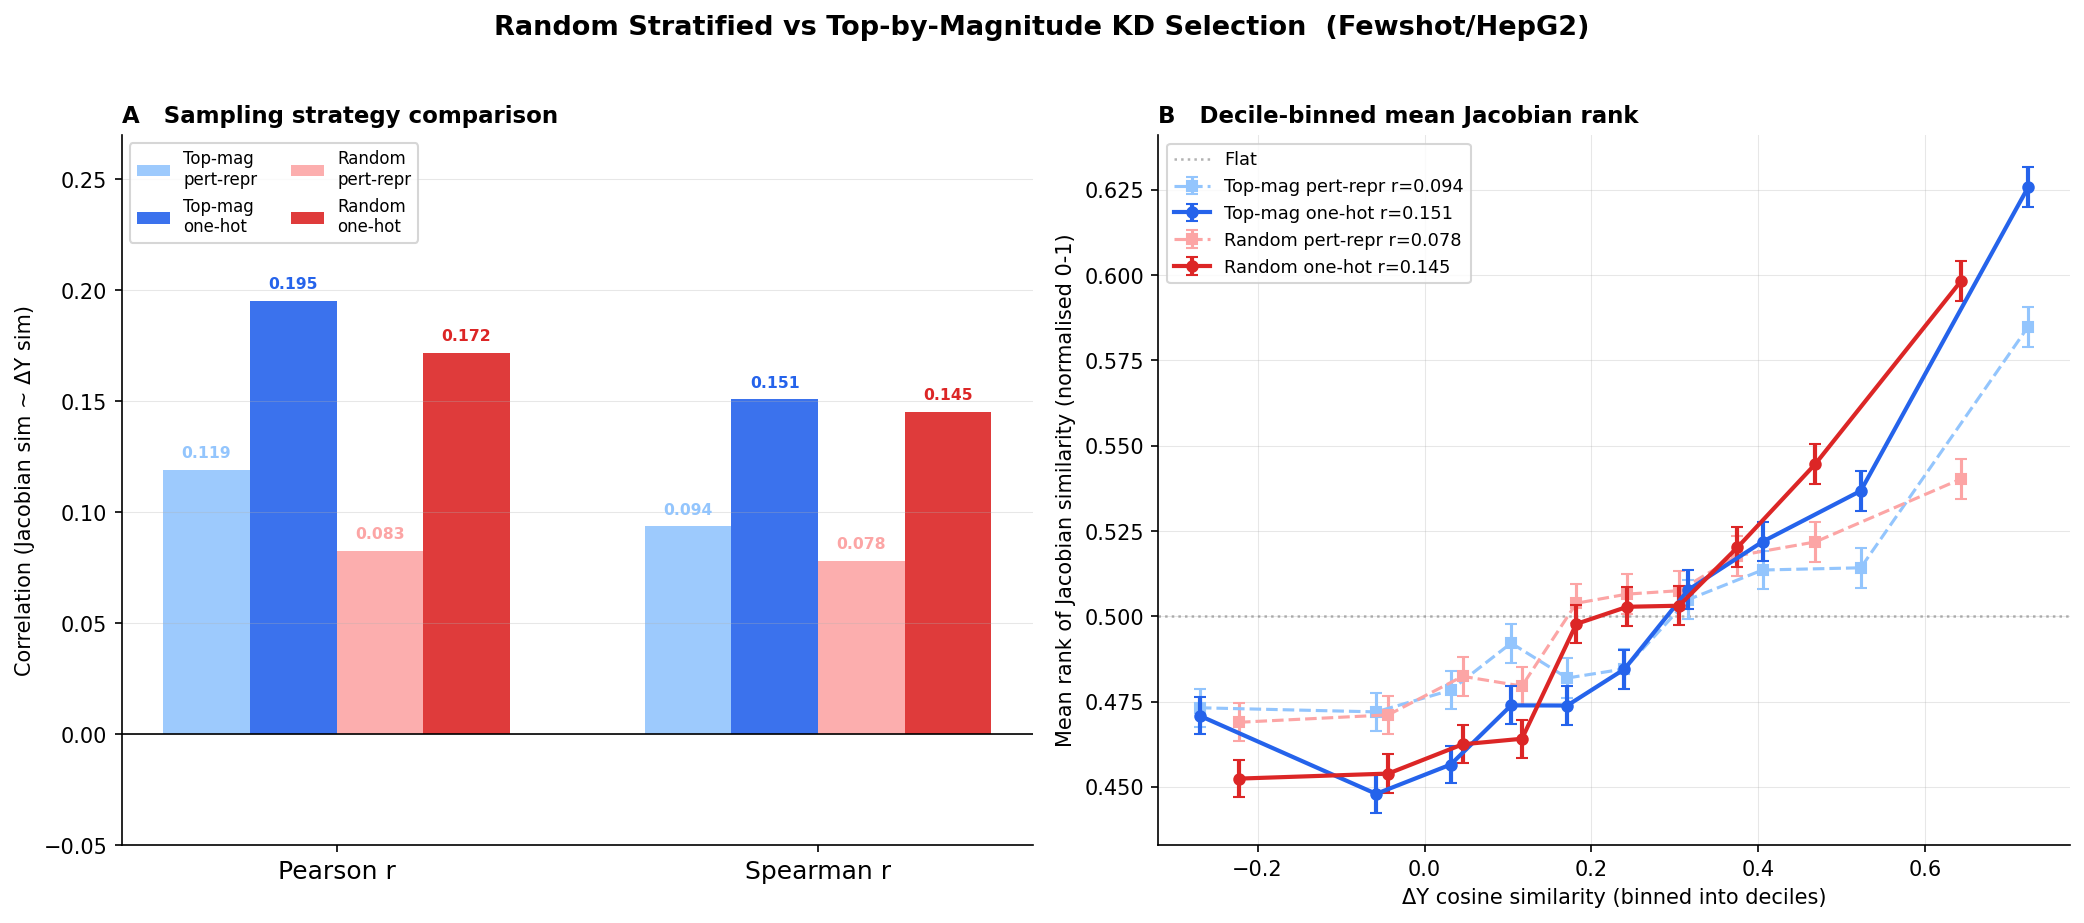

In [4]:

from IPython.display import Image, display
display(Image(filename='/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb09_random_vs_topmag.png', width=1100))


In [5]:

import shutil
src = '/mnt/polished-lake/home/mbeheleramass/notebooks/2026-02-27-18-56_nb09_random_stratified_jacobian.ipynb'
dst = '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb09_random_stratified_jacobian.ipynb'
shutil.copy2(src, dst)
print(f"Saved: {dst}")
